<a href="https://colab.research.google.com/github/Erwdev/DigitalImageProcessing/blob/main/ASSIGNMENT_HANDSON_PCD1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageEnhance

ori_path = '/ori_3.png'
mask_path = '/mask_3.png'

original_img = Image.open(ori_path)
mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

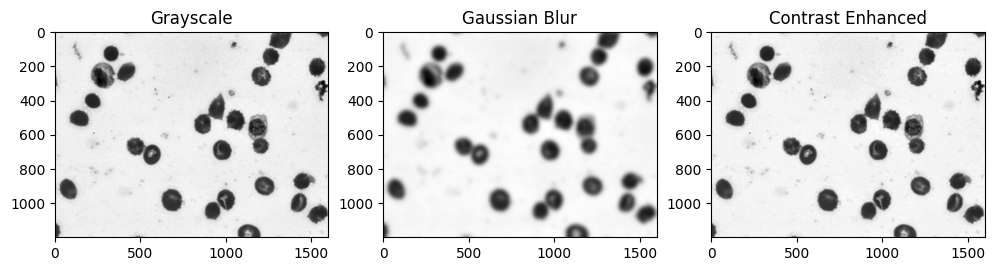

In [ ]:
grayscale_img = original_img.convert('L')#convert into Luminance from RGB img
#L = R * 299/1000 + G * 587/1000 + B * 114/1000
blurred_img = grayscale_img.filter(ImageFilter.GaussianBlur(radius=10))

constrast_enhancer = ImageEnhance.Contrast(grayscale_img)
contrast_enhanced_img = constrast_enhancer.enhance(0.1)

grayscale_array  = np.array(contrast_enhanced_img)
blurred_array = np.array(blurred_img)

plt.figure(figsize = (12,4))
plt.subplot(1,3,1); plt.imshow(grayscale_img, cmap='gray'); plt.title("Grayscale")
plt.subplot(1,3,2); plt.imshow(blurred_img, cmap='gray'); plt.title("Gaussian Blur")
plt.subplot(1,3,3); plt.imshow(contrast_enhanced_img, cmap='gray'); plt.title("Contrast Enhanced")
plt.show()

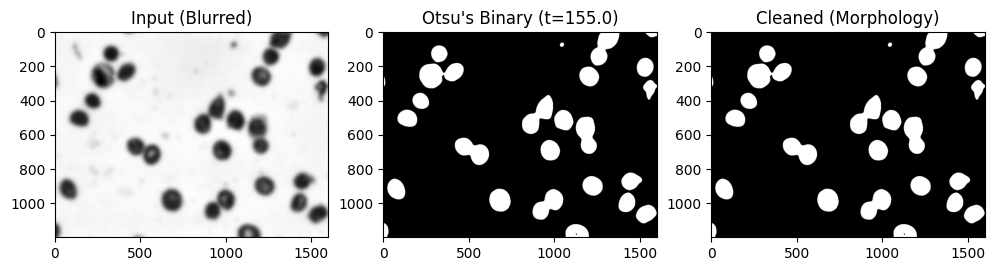

In [ ]:
otsu_threshold_value, otsu_binary_result = cv2.threshold(blurred_array, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# otsu_threshold_value, otsu_binary_result = cv2.adaptiveThreshold(blurred_array, 0, 255,  cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 11,2)
# otsu_threshold_value, otsu_binary_result = cv2.adaptiveThreshold(blurred_array, 255,
#                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
#                                  cv2.THRESH_BINARY, 11, 2)
# otsu_binary_result = cv2.adaptiveThreshold(
#     blurred_array,             # input grayscale image
#     255,                       # max value for binary
#     cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  # adaptive method
#     cv2.THRESH_BINARY,         # threshold type
#     11,                        # block size
#     2                          # constant C
# )

#flipping color ceel turn white
otsu_binary_result = cv2.bitwise_not(otsu_binary_result)

# Morphology
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
otsu_cleaned = cv2.morphologyEx(otsu_binary_result, cv2.MORPH_CLOSE, kernel)
otsu_cleaned = cv2.morphologyEx(otsu_cleaned, cv2.MORPH_OPEN, kernel)


# Displaying result
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(blurred_array, cmap='gray'); plt.title("Input (Blurred)")
plt.subplot(1,3,2); plt.imshow(otsu_binary_result, cmap='gray'); plt.title(f"Otsu's Binary (t={otsu_threshold_value})")
plt.subplot(1,3,3); plt.imshow(otsu_cleaned, cmap='gray'); plt.title("Cleaned (Morphology)")
plt.show()


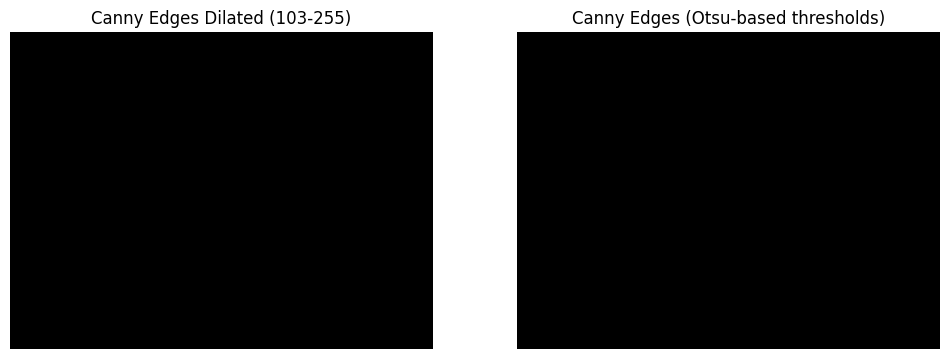

In [ ]:
bilateral_filtered_image = cv2.bilateralFilter(grayscale_array, 9, 75, 75)

canny_otsu_edges = cv2.Canny(
    bilateral_filtered_image, otsu_threshold_value * 0.5,
    otsu_threshold_value
)
# plt.figure(figsize=(12,6))
# plt.imshow(canny_otsu_edges, cmap='gray')
# plt.title(f'Canny Edges (Otsu-based thresholds)')
# plt.axis("off")
# plt.show()

# 3. Canny Median-based thresholds
median_intensity = np.median(bilateral_filtered_image)
canny_lower_threshold = int(max(0, 0.5 * median_intensity))
canny_upper_threshold = int(min(255, 1.5 * median_intensity))

canny_median_edges = cv2.Canny(
    bilateral_filtered_image,
    canny_lower_threshold,
    canny_upper_threshold
)

# 4. Dilate the edges so it will be more clear
edge_dilation_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
canny_dilated_edges = cv2.dilate(canny_median_edges, edge_dilation_kernel, iterations=1)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(canny_dilated_edges, cmap='gray')
plt.title(f'Canny Edges Dilated ({canny_lower_threshold}-{canny_upper_threshold})')
plt.axis("off")


plt.subplot(1,2,2)
plt.imshow(canny_otsu_edges, cmap='gray')
plt.title(f'Canny Edges (Otsu-based thresholds)')
plt.axis("off")


plt.show()

# plt.figure(figsize=(6,6))
# plt.imshow(canny_dilated_edges, cmap='gray')
# plt.title(f'Canny Edges Dilated ({canny_lower_threshold}-{canny_upper_threshold})')
# plt.axis("off")
# plt.show()


Jumlah sel terdeteksi (Otsu segmentation): 26


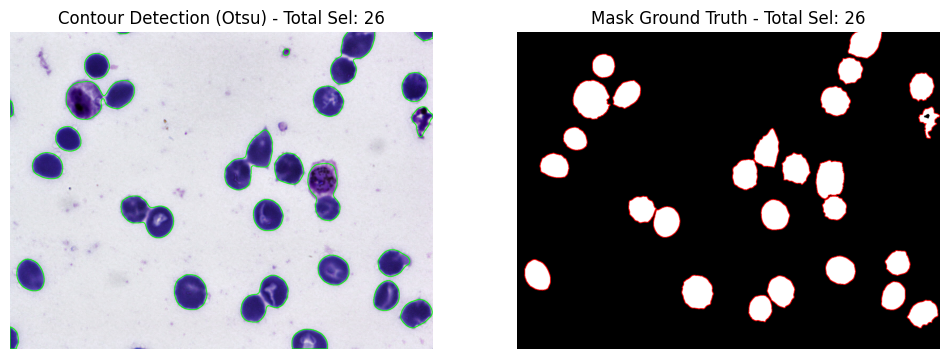

Jumlah sel ground truth (mask): 26


In [ ]:
# --- Contour detection dari hasil Otsu (bisa juga pakai Canny Median Dilated) ---
contours_otsu, _ = cv2.findContours(
    otsu_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

# Gambar kontur di citra original
ori_contour = original_img.copy()
ori_contour_cv = cv2.cvtColor(np.array(ori_contour), cv2.COLOR_RGB2BGR)
cv2.drawContours(ori_contour_cv, contours_otsu, -1, (0,255,0), 2)

# plt.figure(figsize=(7,7))

print("Jumlah sel terdeteksi (Otsu segmentation):", len(contours_otsu))

# --- Contour detection dari Mask Ground Truth ---
mask_array = np.array(mask_img)  # mask asli (gt)
contours_mask, _ = cv2.findContours(mask_array, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

mask_contour = cv2.cvtColor(mask_array, cv2.COLOR_GRAY2BGR)
cv2.drawContours(mask_contour, contours_mask, -1, (0,0,255), 2)  # Merah untuk GT

# plt.figure(figsize=(7,7))


plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(ori_contour_cv, cv2.COLOR_BGR2RGB))
plt.title(f"Contour Detection (Otsu) - Total Sel: {len(contours_otsu)}")
plt.axis("off")
# plt.show()

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(mask_contour, cv2.COLOR_BGR2RGB))
plt.title(f"Mask Ground Truth - Total Sel: {len(contours_mask)}")
plt.axis("off")
plt.show()
#jumlah sel didapat dari jumlah array di list contours_mask

print("Jumlah sel ground truth (mask):", len(contours_mask))


Jumlah sel terdeteksi: 26


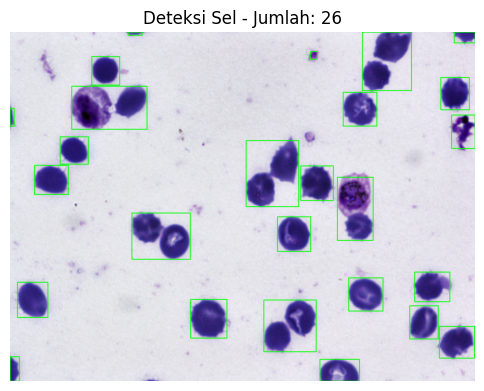

In [ ]:
# --- Contour detection pada hasil Otsu ---
contours_otsu, _ = cv2.findContours(
    otsu_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

# Copy gambar ori untuk ditandai
image_with_contours = cv2.cvtColor(np.array(original_img), cv2.COLOR_RGB2BGR).copy()

# Gambar contour dan hitung jumlahnya # using filtering for bounding box smaller than 50 in area
for cnt in contours_otsu:
    if cv2.contourArea(cnt) > 50:  # filter area kecil agar bukan noise
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(image_with_contours, (x, y), (x+w, y+h), (0,255,0), 2)

cell_count = len([c for c in contours_otsu if cv2.contourArea(c) > 5])

print(f"Jumlah sel terdeteksi: {cell_count}")

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
plt.title(f"Deteksi Sel - Jumlah: {cell_count}")
plt.axis("off")
plt.show()


IoU  (Intersection over Union): 0.8409
Dice Coefficient: 0.9136


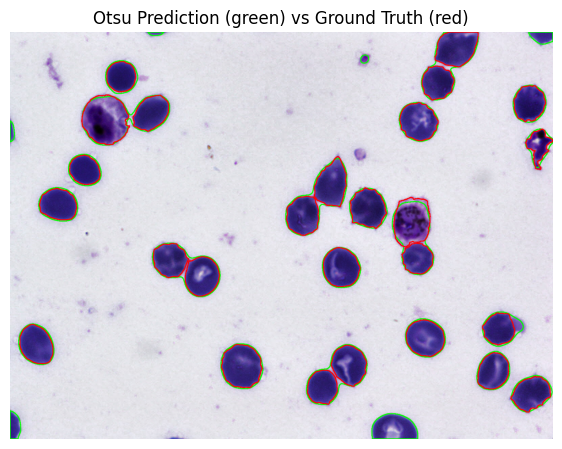

In [ ]:
# Evaluasi Overlap (IoU & Dice)

# Pastikan mask GT biner
_, mask_bin = cv2.threshold(mask_img, 127, 255, cv2.THRESH_BINARY)

# Ubah jadi boolean mask
pred_mask_bool = (otsu_cleaned > 0)
gt_mask_bool   = (mask_bin > 0)

# Hitung IoU dan Dice
intersection = np.logical_and(pred_mask_bool, gt_mask_bool).sum()
union = np.logical_or(pred_mask_bool, gt_mask_bool).sum()
iou = intersection / union if union > 0 else 0.0

dice = (2.0 * intersection) / (pred_mask_bool.sum() + gt_mask_bool.sum()) \
    if (pred_mask_bool.sum() + gt_mask_bool.sum()) > 0 else 0.0

print(f"IoU  (Intersection over Union): {iou:.4f}")
print(f"Dice Coefficient: {dice:.4f}")

# Visualisasi Prediksi vs GT
# Hijau = prediksi Otsu, Merah = Mask GT
overlay_vis = cv2.cvtColor(np.array(original_img), cv2.COLOR_RGB2BGR)

# Kontur prediksi (hijau)
for c in contours_otsu:
    if cv2.contourArea(c) > 50:
        cv2.drawContours(overlay_vis, [c], -1, (0,255,0), 2)

# Kontur GT (merah)
for c in contours_mask:
    if cv2.contourArea(c) > 50:
        cv2.drawContours(overlay_vis, [c], -1, (0,0,255), 2)

plt.figure(figsize=(7,7))
plt.imshow(cv2.cvtColor(overlay_vis, cv2.COLOR_BGR2RGB))
plt.title("Otsu Prediction (green) vs Ground Truth (red)")
plt.axis("off")
plt.show()
